<a href="https://colab.research.google.com/github/alekhya-latech/NHIS/blob/main/COPD_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Performed Feature selection using LASSO(0.005 threshold), Chi2 (top 40) and Information gain(top 40). The common features(22 features) are selected.

Visualisations is done for

General Health status - people with good health status are unlike to get COPD

Smoking status - Everyday and Former smokers have high chance of getting COPD.

Difficulty walking - People with high level of difficult are prone to COPD.

-----Should do visulisations for other selected attributes----

Prediction Algorithms(Decision Tree, KNN, Naive Bayes, AdaBoost) performed and performance matrics like accuracy, recall, precision, specificity, roc are calculated.


In [ ]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
data = pd.read_csv("/content/drive/MyDrive/adult21.csv")
data['COPDEV_A'] = data['COPDEV_A'].replace({
    2: 0,
    7: None,
    8: None,
    9: None
})

data = data.dropna(axis=0,subset= ['COPDEV_A'])
print("Rows and columns count of data: ",len(data), len(data.columns))


Rows and columns count of data:  29443 622


In [ ]:
data['COPDEV_A'].value_counts()

0.0    27760
1.0     1683
Name: COPDEV_A, dtype: int64

In [ ]:
#Remove attributes with more than 5000 missing values

remove_list = []
for i in range(len(data.columns)):
  column_name = data.columns[i]
  if((data[column_name].isnull().sum())>5000):
    remove_list.append(column_name)
data.drop(remove_list, axis=1, inplace=True)
print("Count of attributes having more than 5000 missing values :", len(remove_list))
print("Remaining features count :",len(data.columns))


Count of attributes having more than 5000 missing values : 418
Remaining features count : 204


In [ ]:
data = data.drop(['HHX','WTFA_A'],axis=1)

In [ ]:
# Replacing missing with mode
print("\nFeature\t\t missing_count")
for column_name in data.columns:
  missing_count = data[column_name].isnull().sum()
  if(missing_count!=0):
    print(column_name ,"\t", missing_count)
    mode_value = data[column_name].mode()[0]
    data[column_name].fillna(mode_value, inplace=True)



Feature		 missing_count
MAXEDUCP_A 	 85
INCOTHR_A 	 1216
INCRETIRE_A 	 1216
INCWELF_A 	 1216
INCSSISSDI_A 	 1216
INCSSRR_A 	 1216
WRKHLTHFC_A 	 2748
LIVEHEP_A 	 564
DIBLAST1_A 	 3126
USPLKIND_A 	 2792
WELLNESS_A 	 320
HINOTYR_A 	 2218
STEPS_A 	 2525
WLK13M_A 	 2701
WLK100_A 	 2525
HEARNYRM_A 	 40
HEARQTRM_A 	 29


In [ ]:
#Embedded Methods- LASSO(L1 Regularization)
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

y = data['COPDEV_A']
X = data.drop('COPDEV_A',axis=1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Create and fit the Lasso model
lasso = Lasso(alpha=0.005)  # You can adjust the regularization strength with the alpha parameter
lasso.fit(X_scaled, y)

# Get the non-zero coefficient indices
selected_features_indices = lasso.coef_ != 0

# Print the names of the selected features
lasso = [X.columns[i] for i in range(len(X.columns)) if selected_features_indices[i]]
print("Selected Features: ", lasso)
print(len(lasso))

Selected Features:  ['DISAB3_A', 'PCNTADTWKP_A', 'EMPWRKLSW1_A', 'SMKCIGST_A', 'EMERG12MTC_A', 'MEDICARE_A', 'PRIVATE_A', 'MAXEDUCP_A', 'NUMCAN_A', 'HISP_A', 'AGEP_A', 'INCSSISSDI_A', 'INCSSRR_A', 'MARITAL_A', 'CMPSUPPORT_A', 'SMOKELSEV_A', 'SMELLDF_A', 'PAIFRQ3M_A', 'SHTPNUEV_A', 'SOCWRKLIM_A', 'STEPS_A', 'WLK13M_A', 'WLK100_A', 'EQUIP_A', 'DIFF_A', 'HEARNYRM_A', 'VISIONDF_A', 'DRYMTH12M_A', 'KIDWEAKEV_A', 'ANXEV_A', 'ARTHEV_A', 'ASEV_A', 'MIEV_A', 'CHDEV_A', 'PHSTAT_A']
35


In [ ]:
from sklearn.feature_selection import mutual_info_classif

info_gains = mutual_info_classif(X, y)
feature_scores = pd.DataFrame({'Feature': X.columns, 'Information Gain': info_gains})
feature_scores.sort_values(by='Information Gain', ascending=False, inplace=True)
k = 40  # Number of features to select
gain = feature_scores['Feature'][:k].tolist()
print(gain)

['PHSTAT_A', 'SMKCIGST_A', 'DIFF_A', 'SOCWRKLIM_A', 'SMKEV_A', 'ARTHEV_A', 'AGEP_A', 'DISAB3_A', 'MEDICARE_A', 'HIKIND02_A', 'SHTPNUEV_A', 'EMPWRKLSW1_A', 'PCNTADTWKP_A', 'PAIFRQ3M_A', 'POVRATTC_A', 'PCNTADTWFP_A', 'EQUIP_A', 'ASEV_A', 'DRYMTH12M_A', 'WLK100_A', 'STEPS_A', 'UPPOBJCT_A', 'INCSSRR_A', 'WLK13M_A', 'INCWRKO_A', 'HYPEV_A', 'RX12M_A', 'CHDEV_A', 'MIEV_A', 'KIDWEAKEV_A', 'FAMCARE12M_A', 'HEARINGDF_A', 'PARSTAT_A', 'DEPEV_A', 'DEPMED_A', 'ANXEV_A', 'COGMEMDFF_A', 'INCSSISSDI_A', 'OVER65FLG_A', 'FSNAP12M_A']


In [ ]:
from scipy.stats import chi2_contingency

chi2_scores = []
p_values = []

for feature in X.columns:
    contingency_table = pd.crosstab(X[feature], y)
    chi2, p, _, _ = chi2_contingency(contingency_table)
    chi2_scores.append(chi2)
    p_values.append(p)
features_scores = pd.DataFrame({'Feature': X.columns, 'Chi2 Score': chi2_scores, 'P-value': p_values})
features_scores.sort_values(by='P-value', inplace=True)
k = 40  # Number of features to select
chi = features_scores['Feature'][:k].tolist()
print(chi)

['DIFF_A', 'PHSTAT_A', 'SMKCIGST_A', 'SOCWRKLIM_A', 'DISAB3_A', 'ARTHEV_A', 'SMKEV_A', 'PAIFRQ3M_A', 'EQUIP_A', 'SHTPNUEV_A', 'MEDICARE_A', 'HIKIND02_A', 'WLK13M_A', 'DRYMTH12M_A', 'ASEV_A', 'PCNTADTWKP_A', 'WLK100_A', 'CHDEV_A', 'INCWRKO_A', 'EMPWRKLSW1_A', 'AGEP_A', 'PCNTADTWFP_A', 'STEPS_A', 'INCSSRR_A', 'UPPOBJCT_A', 'HYPEV_A', 'SOCERRNDS_A', 'COGMEMDFF_A', 'SOCSCLPAR_A', 'OVER65FLG_A', 'HEARNYRM_A', 'LEGMSTAT_A', 'MIEV_A', 'VISIONDF_A', 'RX12M_A', 'INCSSISSDI_A', 'HIKIND01_A', 'UPPSLFCR_A', 'UPPRAISE_A', 'MAXEDUCP_A']


In [ ]:
from collections import Counter
selected_list = []
selected_count = Counter(chi+gain+lasso).most_common()
for i in selected_count:
  if(i[1]==3):
    selected_list.append(i[0])
print(selected_list)
print(len(selected_list))

['DIFF_A', 'PHSTAT_A', 'SMKCIGST_A', 'SOCWRKLIM_A', 'DISAB3_A', 'ARTHEV_A', 'PAIFRQ3M_A', 'EQUIP_A', 'SHTPNUEV_A', 'MEDICARE_A', 'WLK13M_A', 'DRYMTH12M_A', 'ASEV_A', 'PCNTADTWKP_A', 'WLK100_A', 'CHDEV_A', 'EMPWRKLSW1_A', 'AGEP_A', 'STEPS_A', 'INCSSRR_A', 'MIEV_A', 'INCSSISSDI_A']
22


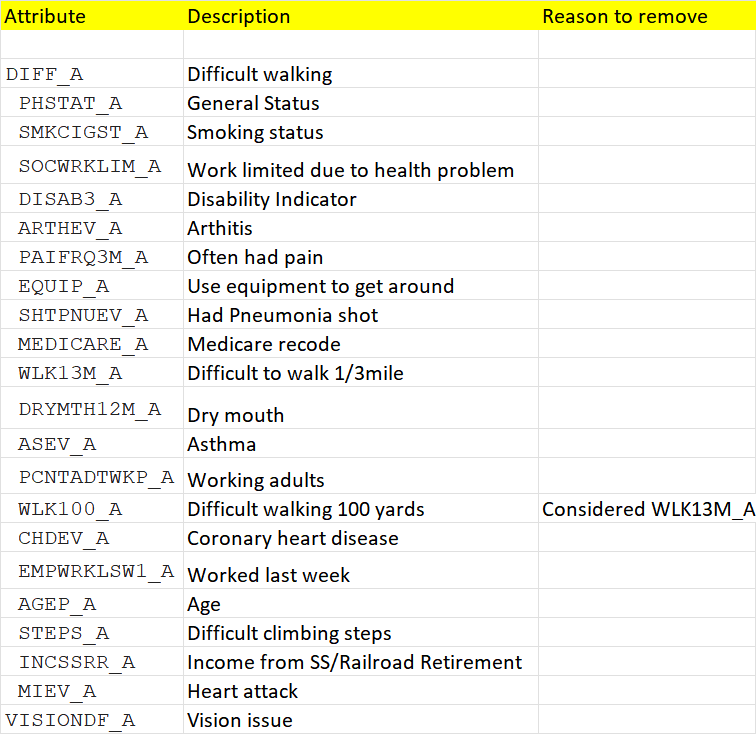

In [ ]:
copd = data[data['COPDEV_A']==1]
print(len(copd))


1683


In [ ]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],str(y[i])+'%')

Error in callback <function _draw_all_if_interactive at 0x7f18910ee0e0> (for post_execute):


KeyboardInterrupt: ignored

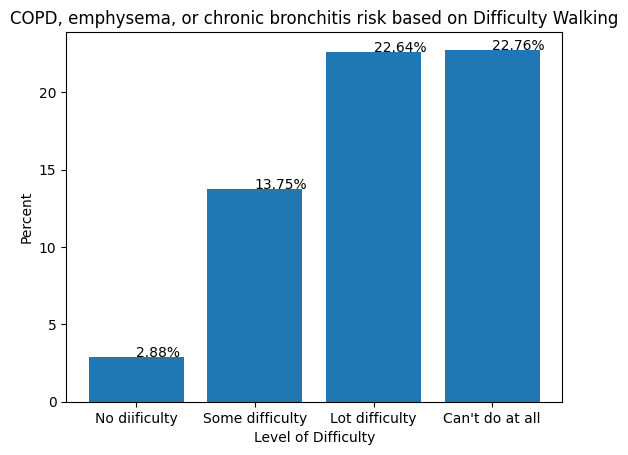

In [ ]:
#Difficulty walking
from matplotlib import pyplot as plt
x = ["No diificulty", "Some difficulty", "Lot difficulty", "Can't do at all"]
y = [round((copd["DIFF_A"].value_counts()[1]/data["DIFF_A"].value_counts()[1])*100,2),round((copd["DIFF_A"].value_counts()[2]/data["DIFF_A"].value_counts()[2])*100,2),
     round((copd["DIFF_A"].value_counts()[3]/data["DIFF_A"].value_counts()[3])*100,2),round((copd["DIFF_A"].value_counts()[4]/data["DIFF_A"].value_counts()[4])*100,2)]
plt.bar(x,y)
plt.title("COPD, emphysema, or chronic bronchitis risk based on Difficulty Walking")
plt.xlabel("Level of Difficulty")
plt.ylabel("Percent")
addlabels(x,y)

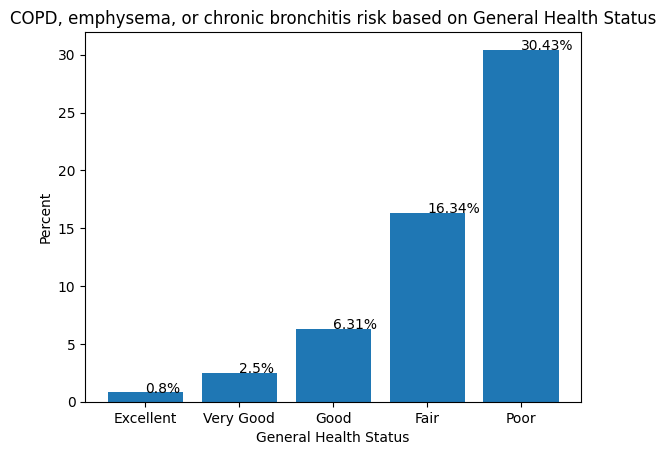

In [ ]:
#PHSTAT_A General HealthStatus

from matplotlib import pyplot as plt
x = ["Excellent", "Very Good", "Good","Fair","Poor"]
y = [round((copd["PHSTAT_A"].value_counts()[1]/data["PHSTAT_A"].value_counts()[1])*100,2),
     round((copd["PHSTAT_A"].value_counts()[2]/data["PHSTAT_A"].value_counts()[2])*100,2),
     round((copd["PHSTAT_A"].value_counts()[3]/data["PHSTAT_A"].value_counts()[3])*100,2),
     round((copd["PHSTAT_A"].value_counts()[4]/data["PHSTAT_A"].value_counts()[4])*100,2),
     round((copd["PHSTAT_A"].value_counts()[5]/data["PHSTAT_A"].value_counts()[5])*100,2)]
plt.bar(x,y)
plt.title("COPD, emphysema, or chronic bronchitis risk based on General Health Status")
plt.xlabel("General Health Status")
plt.ylabel("Percent")
addlabels(x,y)

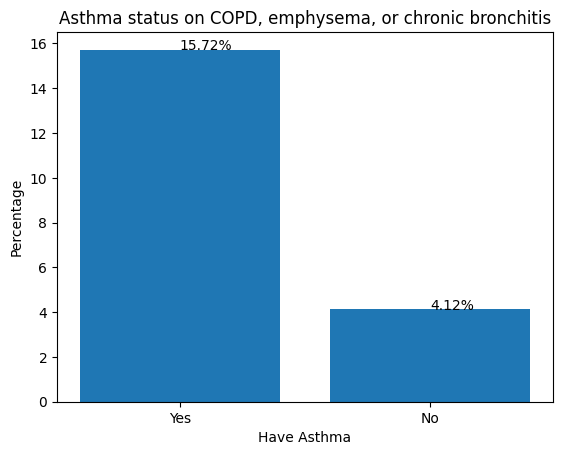

In [ ]:
#Asthma

from matplotlib import pyplot as plt
x = ["Yes","No"]
y = [round((copd["ASEV_A"].value_counts()[1]/data["ASEV_A"].value_counts()[1])*100,2),
     round((copd["ASEV_A"].value_counts()[2]/data["ASEV_A"].value_counts()[2])*100,2)    ]
plt.bar(x,y)
plt.title("Asthma status on COPD, emphysema, or chronic bronchitis")
plt.xlabel("Have Asthma")
plt.ylabel("Percentage")
addlabels(x,y)

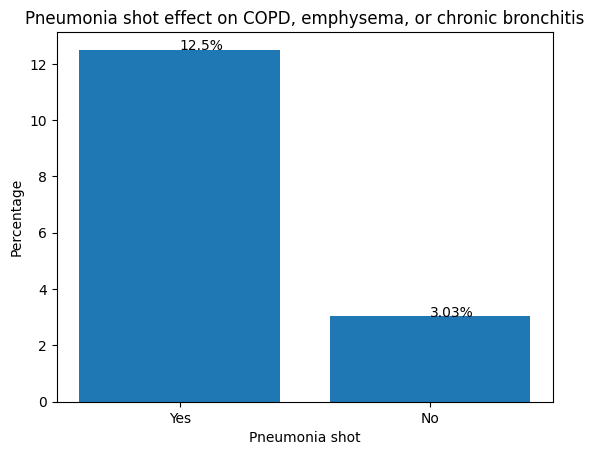

In [ ]:
#Pneumonia shot
from matplotlib import pyplot as plt
x = ["Yes","No"]
y = [round((copd["SHTPNUEV_A"].value_counts()[1]/data["SHTPNUEV_A"].value_counts()[1])*100,2),
     round((copd["SHTPNUEV_A"].value_counts()[2]/data["SHTPNUEV_A"].value_counts()[2])*100,2)    ]
plt.bar(x,y)
plt.title("Pneumonia shot effect on COPD, emphysema, or chronic bronchitis")
plt.xlabel("Pneumonia shot")
plt.ylabel("Percentage")
addlabels(x,y)

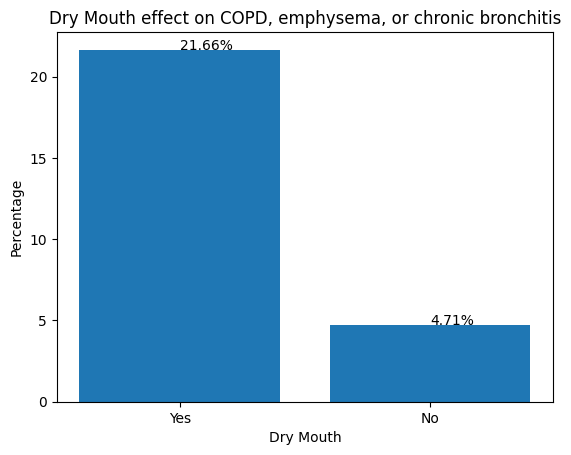

In [ ]:
#Pneumonia shot
from matplotlib import pyplot as plt
x = ["Yes","No"]
y = [round((copd["DRYMTH12M_A"].value_counts()[1]/data["DRYMTH12M_A"].value_counts()[1])*100,2),
     round((copd["DRYMTH12M_A"].value_counts()[2]/data["DRYMTH12M_A"].value_counts()[2])*100,2)    ]
plt.bar(x,y)
plt.title("Dry Mouth effect on COPD, emphysema, or chronic bronchitis")
plt.xlabel("Dry Mouth")
plt.ylabel("Percentage")
addlabels(x,y)

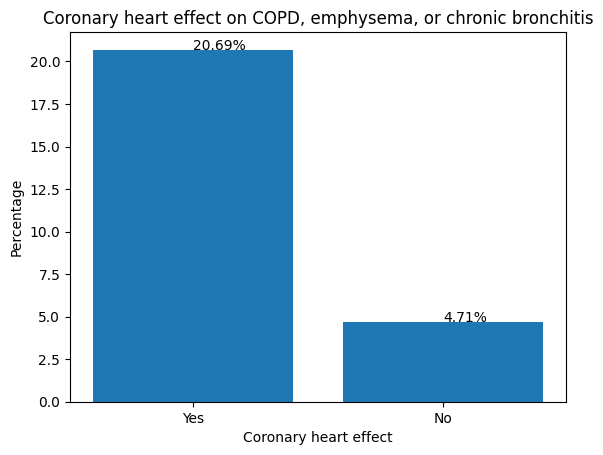

In [ ]:
#Coronary heart disease
from matplotlib import pyplot as plt
x = ["Yes","No"]
y = [round((copd["CHDEV_A"].value_counts()[1]/data["CHDEV_A"].value_counts()[1])*100,2),
     round((copd["CHDEV_A"].value_counts()[2]/data["CHDEV_A"].value_counts()[2])*100,2)    ]
plt.bar(x,y)
plt.title("Coronary heart effect on COPD, emphysema, or chronic bronchitis")
plt.xlabel("Coronary heart effect")
plt.ylabel("Percentage")
addlabels(x,y)

Text(0, 0.5, 'Percent')

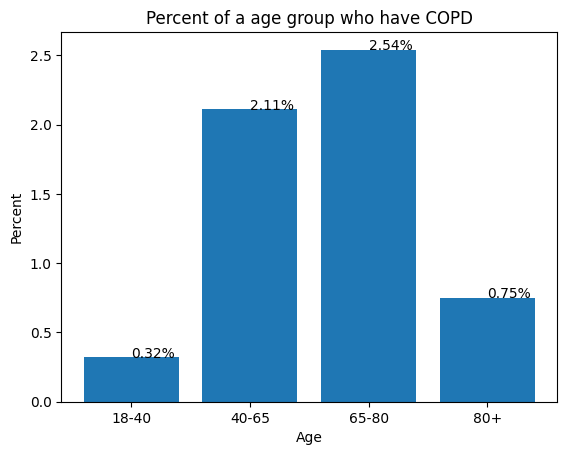

In [ ]:
#Age risk on COPD
from matplotlib import pyplot as plt
u40=0
u65 = 0
u80 = 0
o80=0
for i in copd['AGEP_A']:
  if i<40:
    u40= u40+1
  elif i<65:
    u65 = u65+1
  elif i<80:
    u80 = u80+1
  else:
    o80 = o80+1

def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i,y[i],str(y[i])+'%')

x = ["18-40", "40-65", "65-80", "80+"]
y = [round(u40/len(data)*100,2), round(u65/len(data)*100,2), round(u80/len(data)*100,2), round(o80/len(data)*100,2)]
plt.bar(x,y)
plt.title("Percent of a age group who have COPD")
addlabels(x, y)
plt.xlabel("Age")
plt.ylabel("Percent")


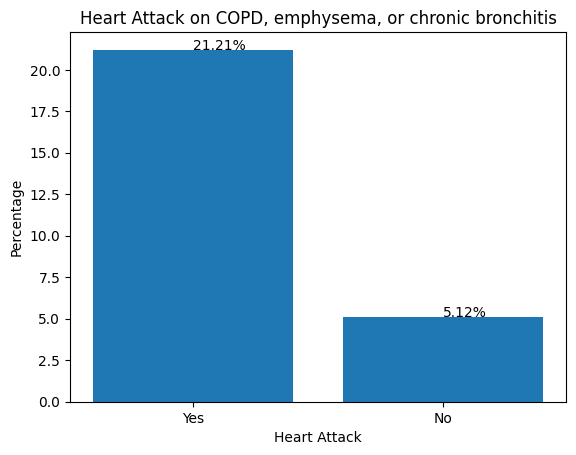

In [ ]:
#Heart Attack
from matplotlib import pyplot as plt
x = ["Yes","No"]
y = [round((copd["MIEV_A"].value_counts()[1]/data["MIEV_A"].value_counts()[1])*100,2),
     round((copd["MIEV_A"].value_counts()[2]/data["MIEV_A"].value_counts()[2])*100,2)    ]
plt.bar(x,y)
plt.title("Heart Attack on COPD, emphysema, or chronic bronchitis")
plt.xlabel("Heart Attack")
plt.ylabel("Percentage")
addlabels(x,y)

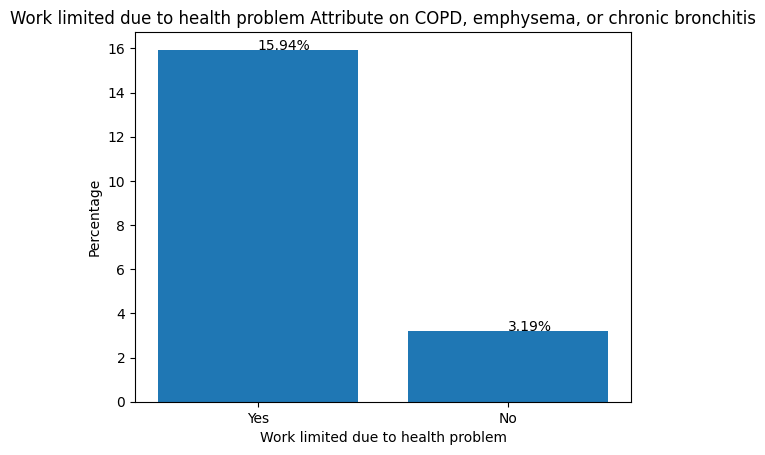

In [ ]:
#Work limited due to health problem
from matplotlib import pyplot as plt
x = ["Yes","No"]
y = [round((copd["SOCWRKLIM_A"].value_counts()[1]/data["SOCWRKLIM_A"].value_counts()[1])*100,2),
     round((copd["SOCWRKLIM_A"].value_counts()[2]/data["SOCWRKLIM_A"].value_counts()[2])*100,2)    ]
plt.bar(x,y)
plt.title("Work limited due to health problem Attribute on COPD, emphysema, or chronic bronchitis")
plt.xlabel("Work limited due to health problem")
plt.ylabel("Percentage")
addlabels(x,y)

In [ ]:
#Arthritis
from matplotlib import pyplot as plt
x = ["Yes","No"]
y = [round((copd["ARTHEV_A"].value_counts()[1]/data["ARTHEV_A"].value_counts()[1])*100,2),
     round((copd["ARTHEV_A"].value_counts()[2]/data["ARTHEV_A"].value_counts()[2])*100,2)    ]
plt.bar(x,y)
plt.title("Arthritis effect on COPD, emphysema, or chronic bronchitis")
plt.xlabel("Arthritis")
plt.ylabel("Percentage")
addlabels(x,y)

NameError: ignored

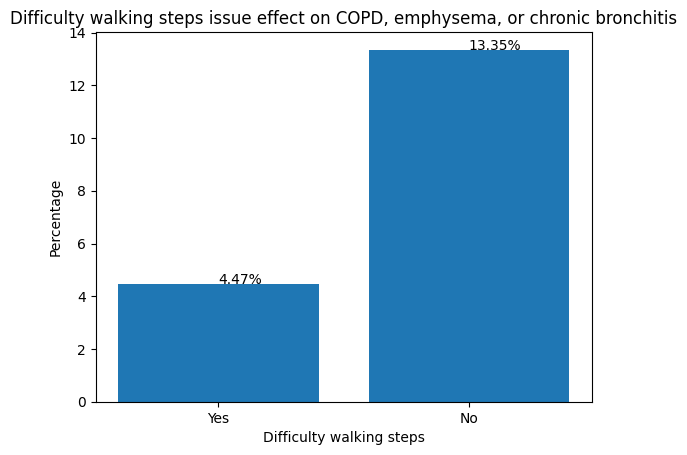

In [ ]:
#Difficulty walking steps
from matplotlib import pyplot as plt
x = ["Yes","No"]
y = [round((copd["STEPS_A"].value_counts()[1]/data["STEPS_A"].value_counts()[1])*100,2),
     round((copd["STEPS_A"].value_counts()[2]/data["STEPS_A"].value_counts()[2])*100,2)    ]
plt.bar(x,y)
plt.title("Difficulty walking steps issue effect on COPD, emphysema, or chronic bronchitis")
plt.xlabel("Difficulty walking steps")
plt.ylabel("Percentage")
addlabels(x,y)

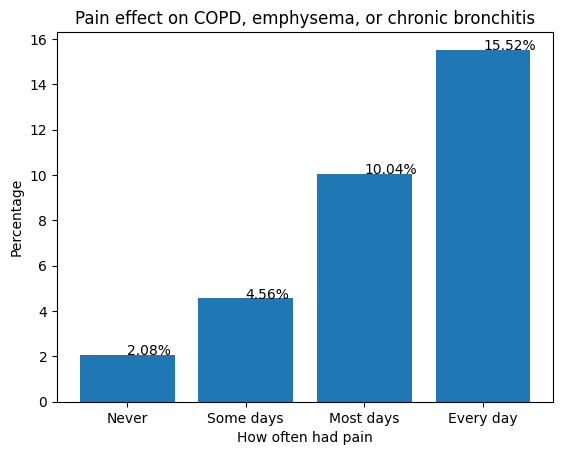

In [ ]:
#How often had pain
from matplotlib import pyplot as plt
x = ["Never","Some days", "Most days", "Every day"]
y = [round((copd["PAIFRQ3M_A"].value_counts()[1]/data["PAIFRQ3M_A"].value_counts()[1])*100,2),
     round((copd["PAIFRQ3M_A"].value_counts()[2]/data["PAIFRQ3M_A"].value_counts()[2])*100,2),
     round((copd["PAIFRQ3M_A"].value_counts()[3]/data["PAIFRQ3M_A"].value_counts()[3])*100,2),
     round((copd["PAIFRQ3M_A"].value_counts()[4]/data["PAIFRQ3M_A"].value_counts()[4])*100,2)]
plt.bar(x,y)
plt.title("Pain effect on COPD, emphysema, or chronic bronchitis")
plt.xlabel("How often had pain")
plt.ylabel("Percentage")
addlabels(x,y)

In [ ]:
selected_list.append('COPDEV_A')


In [ ]:
print(selected_list)

print(data.columns)
print(len(selected_list))
for i in data.columns:
  if i not in selected_list:
    data = data.drop(i,axis=1)
data = data.drop(['WLK100_A'],axis=1)
print(data.columns)

['DIFF_A', 'PHSTAT_A', 'SMKCIGST_A', 'SOCWRKLIM_A', 'DISAB3_A', 'ARTHEV_A', 'PAIFRQ3M_A', 'EQUIP_A', 'SHTPNUEV_A', 'MEDICARE_A', 'WLK13M_A', 'DRYMTH12M_A', 'ASEV_A', 'PCNTADTWKP_A', 'WLK100_A', 'CHDEV_A', 'EMPWRKLSW1_A', 'AGEP_A', 'STEPS_A', 'INCSSRR_A', 'MIEV_A', 'VISIONDF_A', 'INCSSISSDI_A', 'COPDEV_A']
Index(['URBRRL', 'RATCAT_A', 'IMPINCFLG_A', 'PPSU', 'PSTRAT', 'HISPALLP_A',
       'RACEALLP_A', 'DISAB3_A', 'K6SPD_A', 'CITZNSTP_A',
       ...
       'CHDEV_A', 'CHLEV_A', 'HYPEV_A', 'PHSTAT_A', 'AVAIL_A', 'HHSTAT_A',
       'INTV_MON', 'RECTYPE', 'IMPNUM_A', 'POVRATTC_A'],
      dtype='object', length=202)
24
Index(['DISAB3_A', 'PCNTADTWKP_A', 'EMPWRKLSW1_A', 'SMKCIGST_A', 'MEDICARE_A',
       'AGEP_A', 'INCSSISSDI_A', 'INCSSRR_A', 'PAIFRQ3M_A', 'SHTPNUEV_A',
       'SOCWRKLIM_A', 'STEPS_A', 'WLK13M_A', 'EQUIP_A', 'DIFF_A', 'VISIONDF_A',
       'DRYMTH12M_A', 'ARTHEV_A', 'COPDEV_A', 'ASEV_A', 'MIEV_A', 'CHDEV_A',
       'PHSTAT_A'],
      dtype='object')


In [ ]:
print(len(data.columns))
print(len(data))
print("Weights:" , (data['COPDEV_A'].value_counts()[0])/len(data))


23
29443
0.9428387052949767


Oversampling

In [ ]:

from sklearn.datasets import make_classification

X, y = make_classification(
    n_samples=len(data),
    n_features=len(data.columns)-1,
    weights=[0.94],
    flip_y=0,
    random_state=42
)


Decision Tree
Accuracy: 89.28510782815418
Specificity: 0.9312026002166848


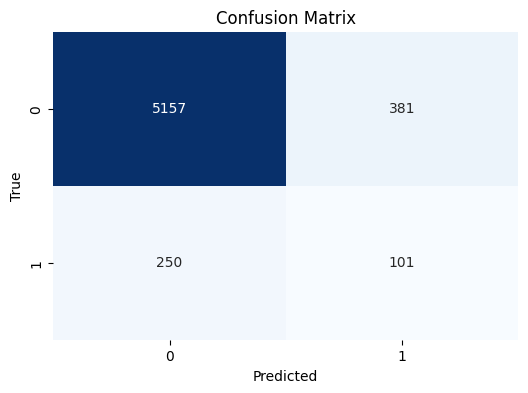

Recall/Sensitivity 0.28774928774928776
Precision: 0.2095435684647303
ROC: 0.6094759439829862
0.8928510782815419 	 0.28774928774928776 	 0.2095435684647303 	 0.6094759439829862 	 0.9312026002166848
Epoch 1/10
1389/1389 [==============================] - 5s 2ms/step - loss: 23.5544
Epoch 2/10
1389/1389 [==============================] - 3s 2ms/step - loss: 0.3059
Epoch 3/10
1389/1389 [==============================] - 3s 2ms/step - loss: 0.3069
Epoch 4/10
1389/1389 [==============================] - 3s 2ms/step - loss: 0.5227
Epoch 5/10
1389/1389 [==============================] - 3s 2ms/step - loss: 0.5226
Epoch 6/10
1389/1389 [==============================] - 4s 3ms/step - loss: 0.5041
Epoch 7/10
1389/1389 [==============================] - 3s 2ms/step - loss: 0.4060
Epoch 8/10
1389/1389 [==============================] - 2s 2ms/step - loss: 0.3485
Epoch 9/10
1389/1389 [==============================] - 2s 2ms/step - loss: 0.3494
Epoch 10/10
185/185 [==============================] - 

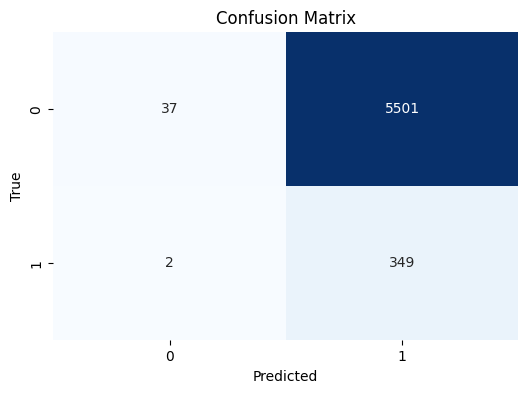

ROC: 0.8189087773775386
0.06554593309560197 	 0.9943019943019943 	 0.05965811965811966 	 0.8189087773775386 	 0.006681112314915132
Naive BAyes
Accuracy: 74.63066734589914
Recall 0.7521367521367521
Precision: 0.15798922800718132
ROC: 0.7490369567834355
0.7463066734589914 	 0.7521367521367521 	 0.15798922800718132 	 0.7490369567834355 	 0.7459371614301191
KNN
Accuracy: 68.16097809475293
Recall 0.6438746438746439
Precision: 0.11437246963562753
ROC: 0.6639380442197343
0.6816097809475293 	 0.6438746438746439 	 0.11437246963562753 	 0.6639380442197343 	 0.6840014445648248
AdaBoost
Accuracy: 93.42842587875701
Recall 0.301994301994302
Precision: 0.4274193548387097
ROC: 0.6381766381766383
0.93428425878757 	 0.301994301994302 	 0.4274193548387097 	 0.6381766381766383 	 0.9743589743589743
GradientBoost
Accuracy: 93.85294617082697
Recall 0.21082621082621084
Precision: 0.46540880503144655
ROC: 0.5977388547811083
0.9385294617082697 	 0.21082621082621084 	 0.46540880503144655 	 0.5977388547811083 	 0

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


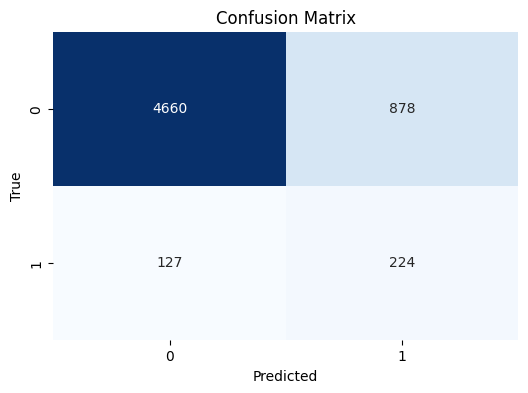

Recall 0.6381766381766382
Precision: 0.20326678765880218
ROC: 0.7398178243248666
0.8293428425878757 	 0.6381766381766382 	 0.20326678765880218 	 0.7398178243248666 	 0.841459010473095


In [ ]:
from imblearn.over_sampling import SMOTE
#Decision Tree
from matplotlib import pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, precision_recall_curve, roc_curve, auc, accuracy_score
import seaborn as sns
import sklearn.metrics as metrics
import pandas as pd


X_train, X_test, y_train, y_test = train_test_split(data.drop('COPDEV_A', axis=1), data['COPDEV_A'], test_size=0.2, random_state=42)

smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

model = DecisionTreeClassifier()

# Performing training
model.fit(X_train_resampled, y_train_resampled)

# # Make predictions on the testing data
y_pred = model.predict(X_test)


# Evaluate the accuracy of the classifier
accuracy = sum(y_pred == y_test) / len(y_test)
print("Decision Tree")
print("Accuracy:", accuracy*100)


cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
# Calculate the recall
recall = recall_score(y_test, y_pred)
print("Recall/Sensitivity", recall)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

#ROC
decision_fpr, decision_tpr, thresholds = roc_curve(y_test, y_pred)
decision_roc_auc = auc(decision_fpr, decision_tpr)
print("ROC:", decision_roc_auc)

print(accuracy,"\t",recall,"\t",precision,"\t",decision_roc_auc,"\t",specificity)


# ANN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense



# Define the model architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32)

# Make predictions
y_pred = model.predict(X_test)

y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
print("ANN")
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)


cm = confusion_matrix(y_test, y_pred_binary)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()

# Calculate specificity
specificity = tn / (tn + fp)
#ROC
ann_fpr, ann_tpr, thresholds = roc_curve(y_test, y_pred)
ann_roc_auc = auc(ann_fpr, ann_tpr)
print("ROC:", ann_roc_auc)
print(accuracy,"\t",recall,"\t",precision,"\t",ann_roc_auc,"\t",specificity)

#Naive Bayes
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()

# Train the classifier
naive_bayes.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = naive_bayes.predict(X_test)

print("Naive BAyes")
accuracy = sum(y_pred == y_test) / len(y_test)
print("Accuracy:", accuracy*100)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#Calculate specificity
specificity = tn / (tn + fp)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print("Recall", recall)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

#ROC
nb_fpr, nb_tpr, thresholds = roc_curve(y_test, y_pred)
nb_roc_auc = auc(nb_fpr, nb_tpr)
print("ROC:", nb_roc_auc)
print(accuracy,"\t",recall,"\t",precision,"\t",nb_roc_auc,"\t",specificity)

from sklearn.neighbors import KNeighborsClassifier
# Create a KNN classifier with k=25
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_resampled, y_train_resampled)
y_pred = knn.predict(X_test)
print("KNN")
accuracy = sum(y_pred == y_test) / len(y_test)
print("Accuracy:", accuracy*100)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print("Recall", recall)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#Calculate specificity
specificity = tn / (tn + fp)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

#ROC
knn_fpr, knn_tpr, thresholds = roc_curve(y_test, y_pred)
knn_roc_auc = auc(knn_fpr, knn_tpr)
print("ROC:", knn_roc_auc)
print(accuracy,"\t",recall,"\t",precision,"\t",knn_roc_auc,"\t",specificity)

#AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel
adaboost = AdaBoostClassifier(n_estimators=200, random_state=42)

# Train the AdaBoost classifier
adaboost.fit(X_train_resampled, y_train_resampled)
y_pred = adaboost.predict(X_test)
print("AdaBoost")
accuracy = sum(y_pred == y_test) / len(y_test)
print("Accuracy:", accuracy*100)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print("Recall", recall)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#Calculate specificity
specificity = tn / (tn + fp)

#ROC
ada_fpr, ada_tpr, thresholds = roc_curve(y_test, y_pred)
ada_roc_auc = auc(ada_fpr, ada_tpr)
print("ROC:", ada_roc_auc)
print(accuracy,"\t",recall,"\t",precision,"\t",ada_roc_auc,"\t",specificity)

#GradientBoost
import xgboost as xgb
from sklearn.metrics import roc_auc_score, recall_score


# Define the parameters for the Gradient Boosting model
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 200
}

# Create the Gradient Boosting model
model = xgb.XGBClassifier(**params)

# Train the model
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test)
print("GradientBoost")
accuracy = sum(y_pred == y_test) / len(y_test)
print("Accuracy:", accuracy*100)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print("Recall", recall)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#Calculate specificity
specificity = tn / (tn + fp)

#ROC
gb_fpr, gb_tpr, thresholds = roc_curve(y_test, y_pred)
gb_roc_auc = auc(gb_fpr, gb_tpr)
print("ROC:", gb_roc_auc)
print(accuracy,"\t",recall,"\t",precision,"\t",gb_roc_auc,"\t",specificity)

#SVM
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Create an SVM classifier
clf = svm.SVC(kernel='linear')

# Train the classifier on the training data
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
predictions = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print("SVM")
print("Accuracy:", accuracy)
recall = recall_score(y_test, y_pred)
print("Recall", recall)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#Calculate specificity
specificity = tn / (tn + fp)

#ROC
svm_fpr, svm_tpr, thresholds = roc_curve(y_test, y_pred)
svm_roc_auc = auc(svm_fpr, svm_tpr)
print("ROC:", svm_roc_auc)
print(accuracy,"\t",recall,"\t",precision,"\t",svm_roc_auc,"\t",specificity)

#Randomforest
from sklearn.ensemble import RandomForestClassifier

#Random forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)
print("Random forest")
# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print("Recall", recall)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate specificity
specificity = tn / (tn + fp)
#ROC
rf_fpr, rf_tpr, thresholds = roc_curve(y_test, y_pred)
rf_roc_auc = auc(rf_fpr, rf_tpr)
print("ROC:", rf_roc_auc)
print(accuracy,"\t",recall,"\t",precision,"\t",rf_roc_auc,"\t",specificity)

#Logistic Regression
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)
y_pred_probs = model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# Convert predicted probabilities to binary labels using the cutoff value of 0.4
y_pred = (y_pred_probs >= 0.5).astype(int)
accuracy = sum(y_pred == y_test) / len(y_test)
#print("Logistic Regression")
print("Accuracy:", accuracy*100)


cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
# Calculate the recall
recall = recall_score(y_test, y_pred)
print("Recall", recall)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate specificity
specificity = tn / (tn + fp)

#ROC
lg_fpr, lg_tpr, thresholds = roc_curve(y_test, y_pred)
lg_roc_auc = auc(lg_fpr, lg_tpr)
print("ROC:", lg_roc_auc)
print(accuracy,"\t",recall,"\t",precision,"\t",lg_roc_auc,"\t",specificity)


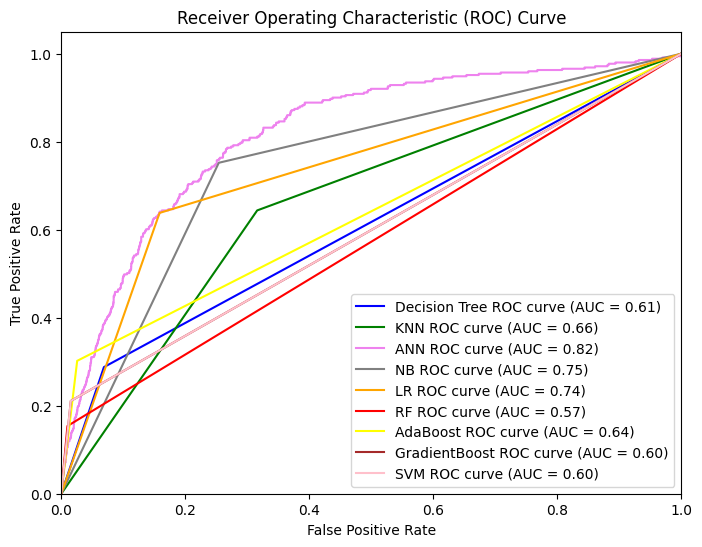

In [ ]:
# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(decision_fpr, decision_tpr, color='blue', label='Decision Tree ROC curve (AUC = %0.2f)' % decision_roc_auc)
plt.plot(knn_fpr, knn_tpr, color='green', label='KNN ROC curve (AUC = %0.2f)' % knn_roc_auc)
plt.plot(ann_fpr, ann_tpr, color='violet', label='ANN ROC curve (AUC = %0.2f)' % ann_roc_auc)
plt.plot(nb_fpr, nb_tpr, color='grey', label='NB ROC curve (AUC = %0.2f)' % nb_roc_auc)
plt.plot(lg_fpr, lg_tpr, color='orange', label='LR ROC curve (AUC = %0.2f)' % lg_roc_auc)
plt.plot(rf_fpr, rf_tpr, color='red', label='RF ROC curve (AUC = %0.2f)' % rf_roc_auc)
plt.plot(ada_fpr, ada_tpr, color='yellow', label='AdaBoost ROC curve (AUC = %0.2f)' % ada_roc_auc)
plt.plot(gb_fpr, gb_tpr, color='brown', label='GradientBoost ROC curve (AUC = %0.2f)' % gb_roc_auc)
plt.plot(gb_fpr, gb_tpr, color='pink', label='SVM ROC curve (AUC = %0.2f)' % svm_roc_auc)





plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Undersampling

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Decision Tree
Accuracy: 24.859908303616912
Specificity: 0.20585048754062837
Recall/Sensitivity 0.9230769230769231
Precision: 0.06861499364675985
ROC: 0.5644637053087758
0.24859908303616912 	 0.9230769230769231 	 0.06861499364675985 	 0.5644637053087758 	 0.20585048754062837
Epoch 1/10
84/84 [==============================] - 1s 2ms/step - loss: 1.8199
Epoch 2/10
84/84 [==============================] - 0s 2ms/step - loss: 0.3162
Epoch 3/10
84/84 [==============================] - 0s 2ms/step - loss: 0.1999
Epoch 4/10
84/84 [==============================] - 0s 1ms/step - loss: 0.1667
Epoch 5/10
84/84 [==============================] - 0s 1ms/step - loss: 0.1548
Epoch 6/10
84/84 [==============================] - 0s 1ms/step - loss: 0.1541
Epoch 7/10
84/84 [==============================] - 0s 1ms/step - loss: 0.1460
Epoch 8/10
84/84 [==============================] - 0s 1ms/step - loss: 0.1363
Epoch 9/10
84/84 [==============================] - 0s 1ms/step - loss: 0.1391
Epoch 10/10
18

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


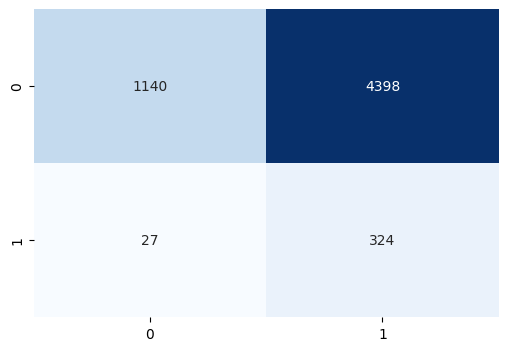

In [ ]:
from imblearn.under_sampling import ClusterCentroids
#Decision Tree
from matplotlib import pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, precision_score, precision_recall_curve, roc_curve, auc, accuracy_score
import seaborn as sns
import sklearn.metrics as metrics
import pandas as pd


X_train, X_test, y_train, y_test = train_test_split(data.drop('COPDEV_A', axis=1), data['COPDEV_A'], test_size=0.2, random_state=42)

cc = ClusterCentroids()
X_train_resampled, y_train_resampled = cc.fit_resample(X_train, y_train)

model = DecisionTreeClassifier()

# Performing training
model.fit(X_train_resampled, y_train_resampled)

# # Make predictions on the testing data
y_pred = model.predict(X_test)


# Evaluate the accuracy of the classifier
accuracy = sum(y_pred == y_test) / len(y_test)
print("Decision Tree")
print("Accuracy:", accuracy*100)


cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", cbar=False)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print("Recall/Sensitivity", recall)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

#ROC
decision_fpr, decision_tpr, thresholds = roc_curve(y_test, y_pred)
decision_roc_auc = auc(decision_fpr, decision_tpr)
print("ROC:", decision_roc_auc)

print(accuracy,"\t",recall,"\t",precision,"\t",decision_roc_auc,"\t",specificity)


# ANN
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense



# Define the model architecture
model = Sequential()
model.add(Dense(64, input_dim=X_train_resampled.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train_resampled, y_train_resampled, epochs=10, batch_size=32)

# Make predictions
y_pred = model.predict(X_test)

y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate accuracy, recall, precision
accuracy = accuracy_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
print("ANN")
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)



tn, fp, fn, tp = confusion_matrix(y_test, y_pred_binary).ravel()

# Calculate specificity
specificity = tn / (tn + fp)
#ROC
ann_fpr, ann_tpr, thresholds = roc_curve(y_test, y_pred)
ann_roc_auc = auc(ann_fpr, ann_tpr)
print("ROC:", ann_roc_auc)
print(accuracy,"\t",recall,"\t",precision,"\t",ann_roc_auc,"\t",specificity)

#Naive Bayes
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()

# Train the classifier
naive_bayes.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = naive_bayes.predict(X_test)

print("Naive BAyes")
accuracy = sum(y_pred == y_test) / len(y_test)
print("Accuracy:", accuracy*100)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#Calculate specificity
specificity = tn / (tn + fp)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print("Recall", recall)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

#ROC
nb_fpr, nb_tpr, thresholds = roc_curve(y_test, y_pred)
nb_roc_auc = auc(nb_fpr, nb_tpr)
print("ROC:", nb_roc_auc)
print(accuracy,"\t",recall,"\t",precision,"\t",nb_roc_auc,"\t",specificity)

from sklearn.neighbors import KNeighborsClassifier
# Create a KNN classifier with k=25
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train_resampled, y_train_resampled)
y_pred = knn.predict(X_test)
print("KNN")
accuracy = sum(y_pred == y_test) / len(y_test)
print("Accuracy:", accuracy*100)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print("Recall", recall)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#Calculate specificity
specificity = tn / (tn + fp)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

#ROC
knn_fpr, knn_tpr, thresholds = roc_curve(y_test, y_pred)
knn_roc_auc = auc(knn_fpr, knn_tpr)
print("ROC:", knn_roc_auc)
print(accuracy,"\t",recall,"\t",precision,"\t",knn_roc_auc,"\t",specificity)

#AdaBoost
from sklearn.ensemble import AdaBoostClassifier
from sklearn.feature_selection import SelectFromModel
adaboost = AdaBoostClassifier(n_estimators=200, random_state=42)

# Train the AdaBoost classifier
adaboost.fit(X_train_resampled, y_train_resampled)
y_pred = adaboost.predict(X_test)
print("AdaBoost")
accuracy = sum(y_pred == y_test) / len(y_test)
print("Accuracy:", accuracy*100)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print("Recall", recall)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#Calculate specificity
specificity = tn / (tn + fp)

#ROC
ada_fpr, ada_tpr, thresholds = roc_curve(y_test, y_pred)
ada_roc_auc = auc(ada_fpr, ada_tpr)
print("ROC:", ada_roc_auc)
print(accuracy,"\t",recall,"\t",precision,"\t",ada_roc_auc,"\t",specificity)

#GradientBoost
import xgboost as xgb
from sklearn.metrics import roc_auc_score, recall_score


# Define the parameters for the Gradient Boosting model
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 3,
    'learning_rate': 0.1,
    'n_estimators': 200
}

# Create the Gradient Boosting model
model = xgb.XGBClassifier(**params)

# Train the model
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
y_pred = model.predict(X_test)
print("GradientBoost")
accuracy = sum(y_pred == y_test) / len(y_test)
print("Accuracy:", accuracy*100)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print("Recall", recall)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#Calculate specificity
specificity = tn / (tn + fp)

#ROC
gb_fpr, gb_tpr, thresholds = roc_curve(y_test, y_pred)
gb_roc_auc = auc(gb_fpr, gb_tpr)
print("ROC:", gb_roc_auc)
print(accuracy,"\t",recall,"\t",precision,"\t",gb_roc_auc,"\t",specificity)

#SVM
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Create an SVM classifier
clf = svm.SVC(kernel='linear')

# Train the classifier on the training data
clf.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test data
predictions = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)
print("SVM")
print("Accuracy:", accuracy)
recall = recall_score(y_test, y_pred)
print("Recall", recall)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

#Calculate specificity
specificity = tn / (tn + fp)

#ROC
svm_fpr, svm_tpr, thresholds = roc_curve(y_test, y_pred)
svm_roc_auc = auc(svm_fpr, svm_tpr)
print("ROC:", svm_roc_auc)
print(accuracy,"\t",recall,"\t",precision,"\t",svm_roc_auc,"\t",specificity)

#Randomforest
from sklearn.ensemble import RandomForestClassifier

#Random forest
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier on the training data
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions on the testing data
y_pred = rf_classifier.predict(X_test)
print("Random forest")
# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the recall
recall = recall_score(y_test, y_pred)
print("Recall", recall)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate specificity
specificity = tn / (tn + fp)
#ROC
rf_fpr, rf_tpr, thresholds = roc_curve(y_test, y_pred)
rf_roc_auc = auc(rf_fpr, rf_tpr)
print("ROC:", rf_roc_auc)
print(accuracy,"\t",recall,"\t",precision,"\t",rf_roc_auc,"\t",specificity)

#Logistic Regression
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train_resampled, y_train_resampled)
y_pred_probs = model.predict_proba(X_test)[:, 1]  # Predicted probabilities for class 1

# Convert predicted probabilities to binary labels using the cutoff value of 0.4
y_pred = (y_pred_probs >= 0.5).astype(int)
accuracy = sum(y_pred == y_test) / len(y_test)
print("Logistic Regression")
print("Accuracy:", accuracy*100)


# Calculate the recall
recall = recall_score(y_test, y_pred)
print("Recall", recall)

precision = precision_score(y_test, y_pred)
print("Precision:", precision)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

# Calculate specificity
specificity = tn / (tn + fp)

#ROC
lg_fpr, lg_tpr, thresholds = roc_curve(y_test, y_pred)
lg_roc_auc = auc(lg_fpr, lg_tpr)
print("ROC:", lg_roc_auc)
print(accuracy,"\t",recall,"\t",precision,"\t",lg_roc_auc,"\t",specificity)


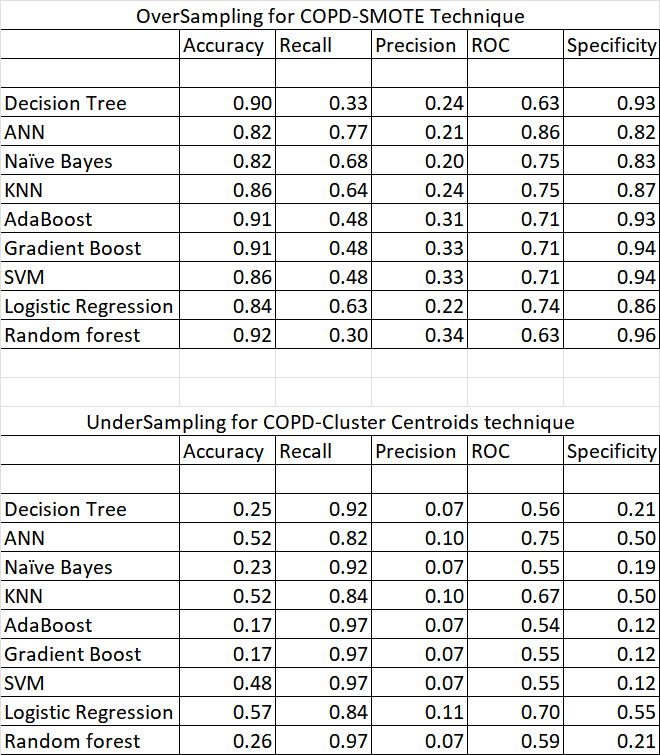

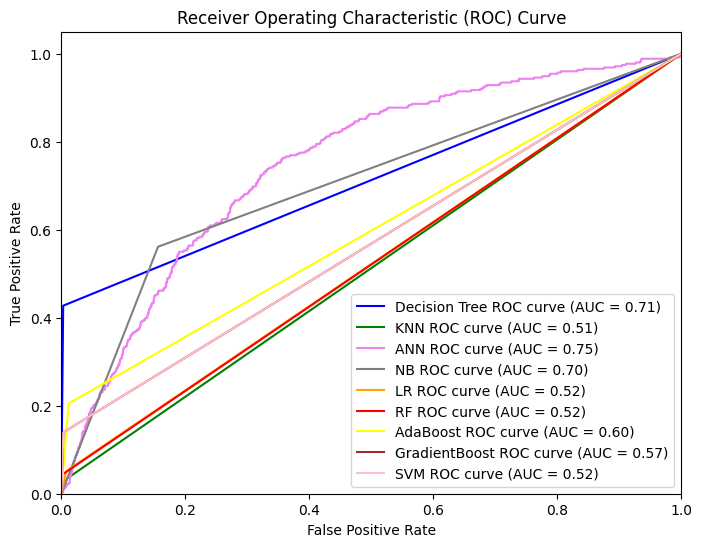

In [ ]:
# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(decision_fpr, decision_tpr, color='blue', label='Decision Tree ROC curve (AUC = %0.2f)' % decision_roc_auc)
plt.plot(knn_fpr, knn_tpr, color='green', label='KNN ROC curve (AUC = %0.2f)' % knn_roc_auc)
plt.plot(ann_fpr, ann_tpr, color='violet', label='ANN ROC curve (AUC = %0.2f)' % ann_roc_auc)
plt.plot(nb_fpr, nb_tpr, color='grey', label='NB ROC curve (AUC = %0.2f)' % nb_roc_auc)
plt.plot(lg_fpr, lg_tpr, color='orange', label='LR ROC curve (AUC = %0.2f)' % lg_roc_auc)
plt.plot(rf_fpr, rf_tpr, color='red', label='RF ROC curve (AUC = %0.2f)' % rf_roc_auc)
plt.plot(ada_fpr, ada_tpr, color='yellow', label='AdaBoost ROC curve (AUC = %0.2f)' % ada_roc_auc)
plt.plot(gb_fpr, gb_tpr, color='brown', label='GradientBoost ROC curve (AUC = %0.2f)' % gb_roc_auc)
plt.plot(gb_fpr, gb_tpr, color='pink', label='SVM ROC curve (AUC = %0.2f)' % svm_roc_auc)





plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()